ThinCurr Python Example: Compute winding surface current for NCSX {#doc_tCurr_regcoil}
==========
In this example we demonstrate how to compute a current potential on one surface that minimizes the error of the normal magnetic field on another. This is relevant to stellarator optimization when the normal field is minimized on a desired plasma surface and the current potential lies on a so-called winding surface here coils will be initialized for further optimization.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) python package, which is installable using `pip` or other standard methods.

In [1]:
import struct
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load ThinCurr library

To load the ThinCurr python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` for binaries on macOS).

In [2]:
thincurr_python_path = os.getenv('OFT_ROOTPATH')
if thincurr_python_path is not None:
    sys.path.append(os.path.join(thincurr_python_path,'python'))
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.ThinCurr import ThinCurr
from OpenFUSIONToolkit.ThinCurr.meshing import build_regcoil_grid, ThinCurr_periodic_toroid

### Generate mesh and ThinCurr input for coil and plasma surfaces for NCSX
First we create ThinCurr models for the winding and plasma surfaces using a REGCOIL definition of the NCSX stellarator using \ref OpenFUSIONToolkit.ThinCurr.meshing.build_regcoil_grid "build_regcoil_grid()". This subroutine builds a uniform grid over one field period, which can then be used by \ref OpenFUSIONToolkit.ThinCurr.meshing.build_periodic_mesh "build_periodic_mesh()" to build a mesh from the resulting grid. The result is a ThinCurr model, including periodicity mapping information (`r_map`).

In [3]:
nphi = 64
ntheta = 64
# Create coil mesh
coil_grid, nfp = build_regcoil_grid('regcoil_out.li383.nc','coil',ntheta,nphi,full_torus=False)
coil_grid = ThinCurr_periodic_toroid(coil_grid,nfp,ntheta,nphi)
# Create plasma mesh
plasma_grid, _ = build_regcoil_grid('regcoil_out.li383.nc','plasma',ntheta,nphi,full_torus=True)
plasma_grid = ThinCurr_periodic_toroid(plasma_grid,1,ntheta,nphi)

### Plot resulting winding surface mesh

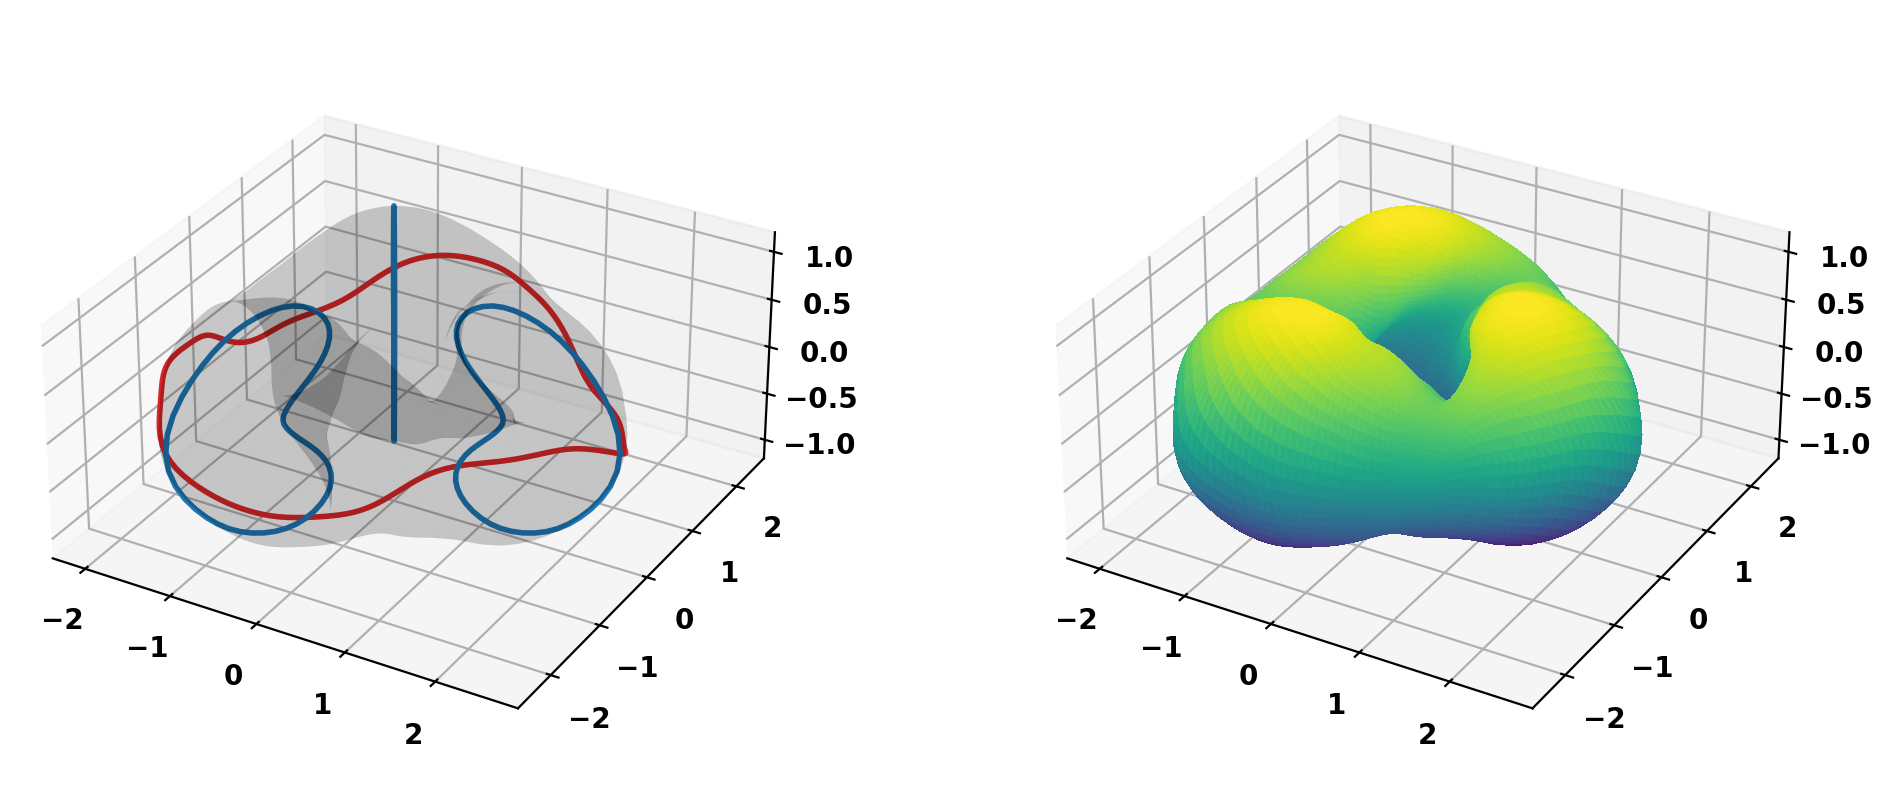

In [4]:
fig = plt.figure(figsize=(12,5))
coil_grid.plot_mesh(fig)

### Plot resulting plasma surface mesh

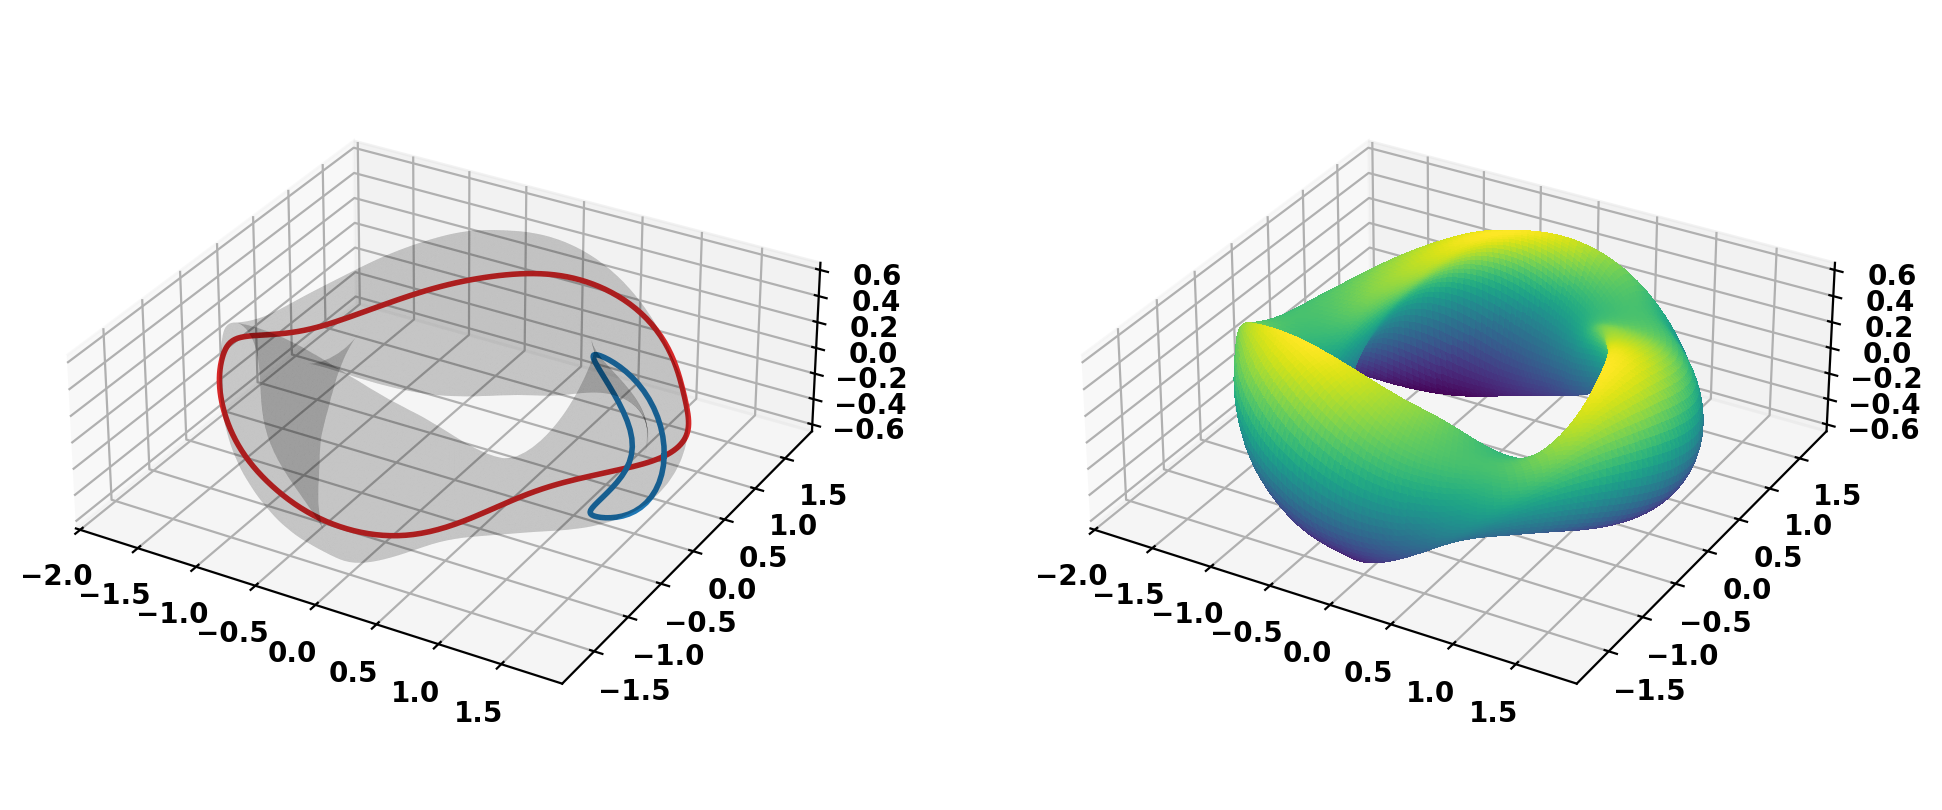

In [5]:
fig = plt.figure(figsize=(12,5))
plasma_grid.plot_mesh(fig)

### Save models to HDF5 format

In [6]:
coil_grid.write_to_file('thincurr_coil.h5')
plasma_grid.write_to_file('thincurr_plasma.h5')


Saving mesh: thincurr_coil.h5

Saving mesh: thincurr_plasma.h5


## Compute optimal winding surface current

### Setup ThinCurr model for winding surface
We now create a \ref OpenFUSIONToolkit.ThinCurr.ThinCurr "ThinCurr" instance for the winding surafce. Once created, we setup the model from the existing HDF5 mesh definition generated above using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_model "setup_model()". We also initialize I/O for this model using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_io "setup_io()" to enable output of plotting files for 3D visualization in [VisIt](https://visit-dav.github.io/visit-website/index.html) or [Paraview](https://www.paraview.org/).

In this case we specify a `coil` directory to use for saving I/O files to keep things separate for the other cases to be run in this notebook and in \ref doc_tCurr_torus_fr.

**Note:** A warning will be generated that no XML node was found and a default resistivity value is being used. This is OK as we will not use the resitivity matrix with this model.

In [7]:
myOFT = OFT_env(nthreads=4)
tw_coil = ThinCurr(myOFT)
tw_coil.setup_model(mesh_file='thincurr_coil.h5')
tw_coil.setup_io(basepath='coil')

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   plotting_reorg
Revision id:          7533014
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    4
Fortran input file    = /var/folders/52/n5qxh27n4w19qxzqygz2btbw0000gn/T/oft_25541/oftpyin                                                                                                                                      
XML input file        = none                                                                                                                                                                                                    
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


Creating thin-wall model
 Orientation depth =       24192
  Loading V(t) driver coils
  Loading I(t) driver coils

  # of points    =        120

### Setup ThinCurr model for plasma surface
We now create a \ref OpenFUSIONToolkit.ThinCurr.ThinCurr "ThinCurr" instance for the winding surafce. Once created, we setup the model from the existing HDF5 mesh definition generated above using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_model "setup_model()". We also initialize I/O for this model using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_io "setup_io()" to enable output of plotting files for 3D visualization in [VisIt](https://visit-dav.github.io/visit-website/index.html) or [Paraview](https://www.paraview.org/).

In this case we specify a `plasma` directory to use for saving I/O files to keep things separate for the other cases to be run in this notebook and in \ref doc_tCurr_torus_fr.

**Note:** A warning will be generated that no XML node was found and a default resistivity value is being used. This is OK as we will not use the resitivity matrix with this model.

In [8]:
tw_plasma = ThinCurr(myOFT)
tw_plasma.setup_model(mesh_file='thincurr_plasma.h5')
tw_plasma.setup_io(basepath='plasma')


Creating thin-wall model
 Orientation depth =       24576
  Loading V(t) driver coils
  Loading I(t) driver coils

  # of points    =        12288
  # of edges     =        36864
  # of cells     =        24576
  # of holes     =            2
  # of Vcoils    =            0
  # of closures  =            1
  # of Icoils    =            0

  Building holes


### Compute mutual inductance between coil and plasma surfaces

In [9]:
coupling = tw_coil.cross_coupling(tw_plasma,cache_file='Lmat_coupling.save')
coupling_new = coil_grid.condense_matrix(coupling,axis=0)
hole_start = coupling_new.shape[1]-2
del coupling

 Building element<->element mutual inductance matrix
     Time =  1m  8s      


### Compute coil current regularization matrix

In [10]:
reg_mat = tw_coil.get_regmat()
ncold = int(reg_mat.shape[1]/nfp)
reg_new = coil_grid.condense_matrix(reg_mat[:,:ncold],axis=0)
del reg_mat

### Compute optimal current distribution with specified regularization

In [11]:
lam = 1.E-4
wt1 = 1.E-13
wt2 = 2.E-3
#
reg_coupling = np.hstack((coupling_new,lam*reg_new))
lhs = np.zeros((reg_coupling.shape[1],))
#
lhs[hole_start] = 1.E0
reg_coupling[:,hole_start] *= wt1/lhs[hole_start]
lhs[hole_start] *= wt1/lhs[hole_start]
#
lhs[hole_start+1] = 1.E0
reg_coupling[:,hole_start+1] *= wt2/lhs[hole_start+1]
lhs[hole_start+1] *= wt2/lhs[hole_start+1]
#
reg_coupling[:,-2]=0.0; reg_coupling[-2,-2]=1.0
#
ls_output = np.linalg.lstsq(np.transpose(reg_coupling), lhs, rcond=None)
rhs = ls_output[0]

### Save error and current distribution for plotting

In [12]:
# Save error
tmp_err = np.dot(np.transpose(coupling_new),rhs)
tw_plasma.save_scalar(tmp_err[:-1],'E')
_ = tw_plasma.build_XDMF()

# Expand current potential to holes and save
tw_coil.save_current(coil_grid.expand_vector(rhs),'J')
_ = tw_coil.build_XDMF()

Removing old Xdmf files
  Removed 1 files

Creating output files: oft_xdmf.XXXX.h5
  Found Group: ThinCurr
    Found Mesh: smesh
Removing old Xdmf files
  Removed 1 files

Creating output files: oft_xdmf.XXXX.h5
  Found Group: ThinCurr
    Found Mesh: smesh


### Plot current potential on one field period

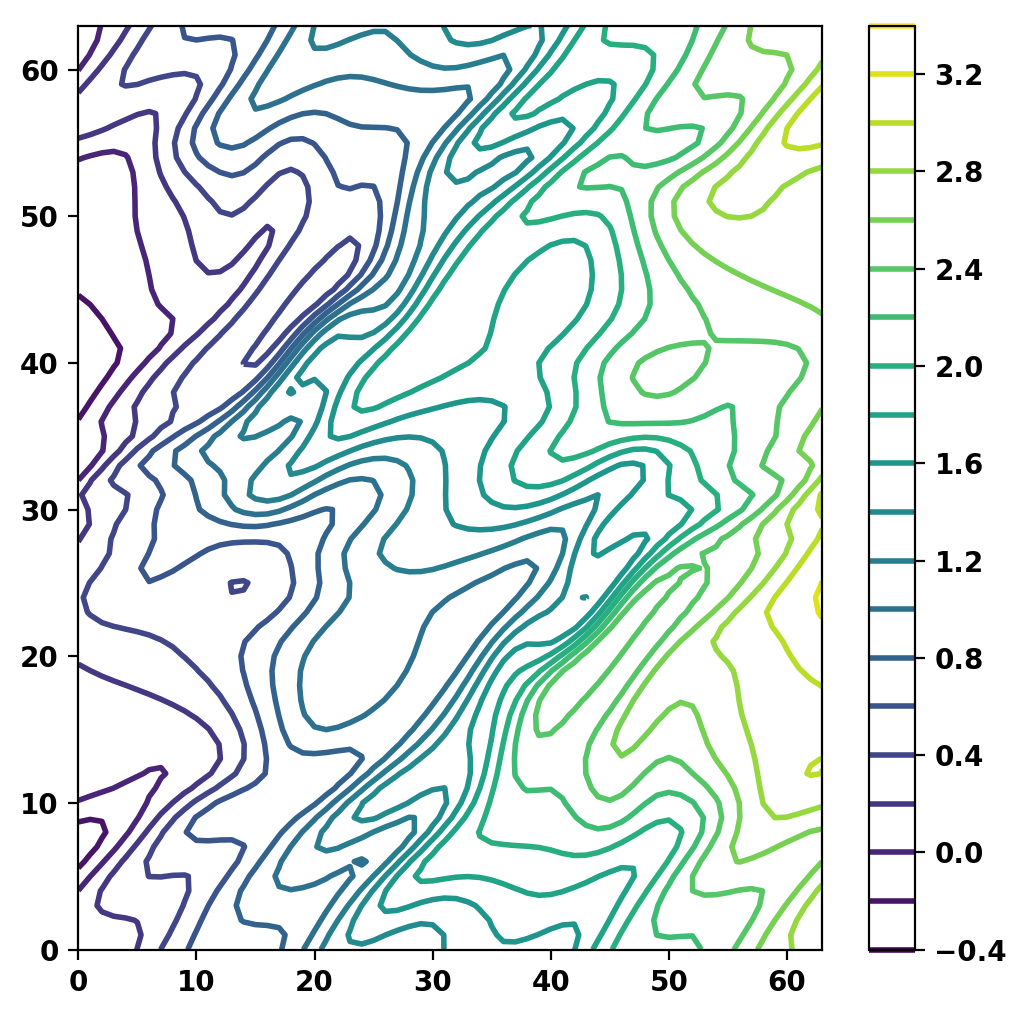

In [13]:
fig, ax = plt.subplots(1,1)
clf = ax.contour(coil_grid.unique_to_nodes_2D(rhs),20)
_ = fig.colorbar(clf)

### Plot normalized field error on one field period

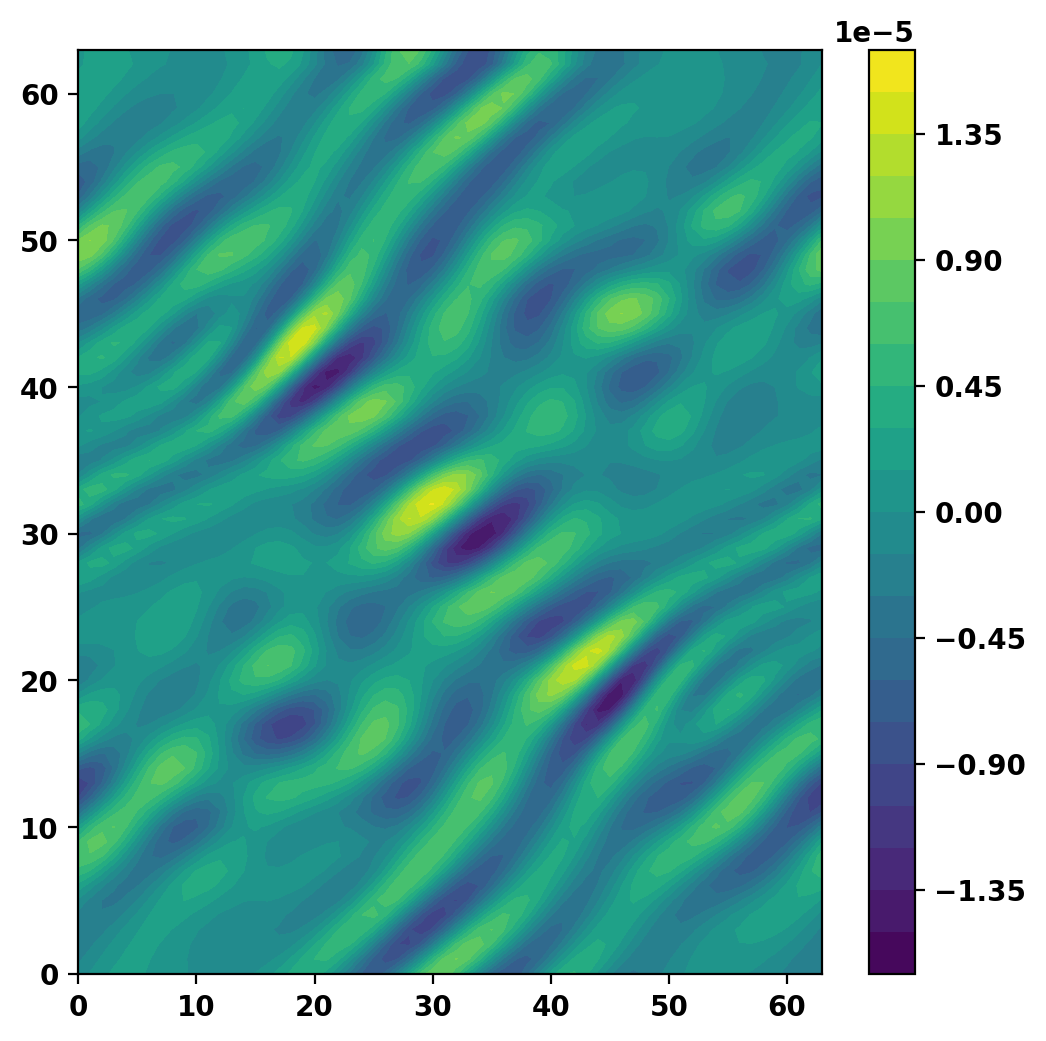

In [14]:
data_unwrap=tmp_err[:64*64].reshape((64,64))
fig, ax = plt.subplots(1,1)
clf = ax.contourf(data_unwrap.transpose(),20)
_ = fig.colorbar(clf)